#I. Mô tả vấn đề

#II. Các gói và thư viện cần thiết

##1. Cài đặt FinRL

In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

!pip install stable-baselines[mpi]

!pip uninstall tensorflow --yes
!pip install tensorflow==1.15.4

!pip uninstall sklearn --yes
!pip install scikit-learn==0.21.1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import warnings
warnings.filterwarnings("ignore")

##2. Các gói cần thiết

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

## 3. Tạo các thư mục cần thiết

In [ ]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [ ]:
config.RESULTS_DIR

'results'

# III. Tiền xử lý dữ liệu

Kiểm tra dữ liệu bị thiếu và thực hiện feature engineering để chuyển đổi dữ liệu phù hợp với mô hình.

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/cs106_source/data/dow30_feb2018/dow30_2009_2022.csv')

In [ ]:
df

,date,open,high,low,close,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,2.771175,746015200,AAPL
1,2009-01-05,3.327500,3.435000,3.311071,2.888129,1181608400,AAPL
2,2009-01-06,3.426786,3.470357,3.299643,2.840492,1289310400,AAPL
3,2009-01-07,3.278929,3.303571,3.223571,2.779114,753048800,AAPL
4,2009-01-08,3.229643,3.326786,3.215714,2.830719,673500800,AAPL
...,...,...,...,...,...,...,...
101485,2022-06-03,97.900002,99.660004,97.900002,99.089996,21032800,XOM
101486,2022-06-06,99.180000,99.779999,98.669998,98.839996,20682100,XOM
101487,2022-06-07,99.699997,103.430000,99.489998,103.370003,37810200,XOM
101488,2022-06-08,103.489998,105.570000,102.980003,104.589996,31613200,XOM


In [ ]:
df['tic'].unique()

array(['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE', 'GS',
       'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK',
       'MSFT', 'NKE', 'PFE', 'PG', 'RTX', 'TRV', 'UNH', 'V', 'VZ', 'WMT',
       'XOM'], dtype=object)

## 1. Kiểm tra dữ liệu bị thiếu

In [ ]:
df.isnull().values.any()

False

In [ ]:
for tic in df['tic'].unique():
  count_tic = len(df[(df['tic']== tic)])
  print(tic, count_tic) 

AAPL 3383
AXP 3383
BA 3383
CAT 3383
CSCO 3383
CVX 3383
DD 3383
DIS 3383
GE 3383
GS 3383
HD 3383
IBM 3383
INTC 3383
JNJ 3383
JPM 3383
KO 3383
MCD 3383
MMM 3383
MRK 3383
MSFT 3383
NKE 3383
PFE 3383
PG 3383
RTX 3383
TRV 3383
UNH 3383
V 3383
VZ 3383
WMT 3383
XOM 3383


## 2. Thêm chỉ báo kĩ thuật và chỉ số nhiễu loạn (turbulence index)

Nhóm sử dụng 4 chỉ báo kĩ thuật là:
- MACD: Moving Average Convergence Divergence
- RSI: Relative Strength Index
- CCI: Commodity Channel Index
- ADX: Average Directional Index (ADX)



```
class FeatureEngineer:
    """
    Provides methods for preprocessing the stock price data

    Attributes
    ----------
        df: DataFrame
            data downloaded from Yahoo API
        feature_number : int
            number of features we used
        use_technical_indicator : boolean
            we technical indicator or not
        use_turbulence : boolean
            use turbulence index or not

    Methods
    -------
        preprocess_data()
            main method to do the feature engineering
    """
```



In [ ]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
#list_INDICATORS = config.INDICATORS[0:6]

list_INDICATORS = ['macd', 'rsi_30', 'cci_30', 'dx_30']

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = list_INDICATORS,
                    #use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.rename(columns={'rsi_30': 'rsi', 'cci_30': 'cci', 'dx_30': 'adx'}, inplace=True)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head()

,date,tic,open,high,low,close,volume,macd,rsi,cci,adx,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.771175,746015200.0,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,AXP,18.570000,19.520000,18.400000,15.477425,10955700.0,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,BA,42.799999,45.560001,42.779999,33.941090,7010200.0,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,CAT,44.910000,46.980000,44.709999,32.164726,7117200.0,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.265080,40980600.0,0.0,100.0,66.666667,100.0,0.0


In [ ]:
len(processed_full['tic'].unique())

30

In [ ]:
processed_full.to_csv('/content/gdrive/MyDrive/cs106_source/data/data_done_2009_2022.csv', index=False)

# IV. Thiết kế môi trường

In [ ]:
processed_full = pd.read_csv('/content/gdrive/MyDrive/cs106_source/data/data_done_2009_2022.csv')

## 1. Chia dữ liệu

In [ ]:
import numpy as np
import pandas as pd
from stockstats import StockDataFrame as Sdf
#from config import config


def data_split(df,start,end):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df.date >= start) & (df.date < end)]
    data=data.sort_values(['date','tic'],ignore_index=True)
    #data  = data[final_columns]
    data.index = data.date.factorize()[0]
    return data

##2. Môi trường đào tạo

In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001
REWARD_SCALING = 1e-4

class StockEnvTrain(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df

        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (181,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False             
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.close.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.trades = 0
        #self.reset()
        self._seed()


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass

    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)

        self.state[index+STOCK_DIM+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        #print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        #print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('results/account_value_train.png')
            plt.close()
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            #print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('results/account_value_train.csv')
            #print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- INITIAL_ACCOUNT_BALANCE ))
            #print("total_cost: ", self.cost)
            #print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            #print("Sharpe: ",sharpe)
            #print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('/content/gdrive/MyDrive/cs106_source/results/account_rewards_train.csv')
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))

            actions = actions * HMAX_NORMALIZE
            #actions = (actions.astype(int))
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.close.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() + \
                    self.data.cci.values.tolist() + \
                    self.data.adx.values.tolist()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*REWARD_SCALING



        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.close.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist() 
        # iteration += 1 
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

##3. Môi trường xác thực

In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

# turbulence index: 90-150 reasonable threshold
#TURBULENCE_THRESHOLD = 140
REWARD_SCALING = 1e-4

class StockEnvValidation(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, day = 0, turbulence_threshold=140, iteration=''):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (181,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.close.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        #self.reset()
        self._seed()
        
        self.iteration=iteration


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.turbulence<self.turbulence_threshold:
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += \
                self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 (1- TRANSACTION_FEE_PERCENT)
                
                self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
                self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
        else:
            # if turbulence goes over threshold, just clear out all positions 
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              (1- TRANSACTION_FEE_PERCENT)
                self.state[index+STOCK_DIM+1] =0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        if self.turbulence< self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            # print('available_amount:{}'.format(available_amount))
            
            #update balance
            self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                              (1+ TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] += min(available_amount, action)
            
            self.cost+=self.state[index+1]*min(available_amount, action)* \
                              TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            # if turbulence goes over threshold, just stop buying
            pass
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('results/account_value_validation_{}.png'.format(self.iteration))
            plt.close()
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('results/account_value_validation_{}.csv'.format(self.iteration))
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("previous_total_asset:{}".format(self.asset_memory[0]))           

            #print("end_total_asset:{}".format(end_total_asset))
            #print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- self.asset_memory[0] ))
            #print("total_cost: ", self.cost)
            #print("total trades: ", self.trades)

            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (4**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            #print("Sharpe: ",sharpe)
            
            #df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('/content/gdrive/MyDrive/cs106_source/results/account_rewards_trade_{}.csv'.format(self.iteration))
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))

            actions = actions * HMAX_NORMALIZE
            #actions = (actions.astype(int))
            if self.turbulence>=self.turbulence_threshold:
                actions=np.array([-HMAX_NORMALIZE]*STOCK_DIM)
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.turbulence = self.data['turbulence'].values[0]
            #print(self.turbulence)
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.close.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() + \
                    self.data.cci.values.tolist() + \
                    self.data.adx.values.tolist()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*REWARD_SCALING

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        #self.iteration=self.iteration
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.close.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist()  + \
                      self.data.cci.values.tolist()  + \
                      self.data.adx.values.tolist() 
            
        return self.state
    
    def render(self, mode='human',close=False):
        return self.state
    

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

##4. Môi trường giao dịch


In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

# turbulence index: 90-150 reasonable threshold
#TURBULENCE_THRESHOLD = 140
REWARD_SCALING = 1e-4

class StockEnvTrade(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0,turbulence_threshold=140
                 ,initial=True, previous_state=[], model_name='', iteration=''):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        self.initial = initial
        self.previous_state = previous_state
        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (181,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.close.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        #self.reset()
        self._seed()
        self.model_name=model_name        
        self.iteration=iteration


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.turbulence<self.turbulence_threshold:
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += \
                self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 (1- TRANSACTION_FEE_PERCENT)
                
                self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
                self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
        else:
            # if turbulence goes over threshold, just clear out all positions 
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              (1- TRANSACTION_FEE_PERCENT)
                self.state[index+STOCK_DIM+1] =0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        if self.turbulence< self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            # print('available_amount:{}'.format(available_amount))
            
            #update balance
            self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                              (1+ TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] += min(available_amount, action)
            
            self.cost+=self.state[index+1]*min(available_amount, action)* \
                              TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            # if turbulence goes over threshold, just stop buying
            pass
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('results/account_value_trade_{}_{}.png'.format(self.model_name, self.iteration))
            plt.close()
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('results/account_value_trade_{}_{}.csv'.format(self.model_name, self.iteration))
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0]))           

            print("end_total_asset:{}".format(end_total_asset))
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- self.asset_memory[0] ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)

            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (4**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            print("Sharpe: ",sharpe)
            
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('results/account_rewards_trade_{}_{}.csv'.format(self.model_name, self.iteration))
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))

            actions = actions * HMAX_NORMALIZE
            #actions = (actions.astype(int))
            if self.turbulence>=self.turbulence_threshold:
                actions=np.array([-HMAX_NORMALIZE]*STOCK_DIM)
                
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.turbulence = self.data['turbulence'].values[0]
            #print(self.turbulence)
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.close.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() + \
                    self.data.cci.values.tolist() + \
                    self.data.adx.values.tolist()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*REWARD_SCALING


        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        if self.initial:
            self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
            self.day = 0
            self.data = self.df.loc[self.day,:]
            self.turbulence = 0
            self.cost = 0
            self.trades = 0
            self.terminal = False 
            #self.iteration=self.iteration
            self.rewards_memory = []
            #initiate state
            self.state = [INITIAL_ACCOUNT_BALANCE] + \
                          self.data.close.values.tolist() + \
                          [0]*STOCK_DIM + \
                          self.data.macd.values.tolist() + \
                          self.data.rsi.values.tolist()  + \
                          self.data.cci.values.tolist()  + \
                          self.data.adx.values.tolist() 
        else:
            previous_total_asset = self.previous_state[0]+ \
            sum(np.array(self.previous_state[1:(STOCK_DIM+1)])*np.array(self.previous_state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory = [previous_total_asset]
            #self.asset_memory = [self.previous_state[0]]
            self.day = 0
            self.data = self.df.loc[self.day,:]
            self.turbulence = 0
            self.cost = 0
            self.trades = 0
            self.terminal = False 
            #self.iteration=iteration
            self.rewards_memory = []
            #initiate state
            #self.previous_state[(STOCK_DIM+1):(STOCK_DIM*2+1)]
            #[0]*STOCK_DIM + \

            self.state = [ self.previous_state[0]] + \
                          self.data.close.values.tolist() + \
                          self.previous_state[(STOCK_DIM+1):(STOCK_DIM*2+1)]+ \
                          self.data.macd.values.tolist() + \
                          self.data.rsi.values.tolist()  + \
                          self.data.cci.values.tolist()  + \
                          self.data.adx.values.tolist() 
            
        return self.state
    
    def render(self, mode='human',close=False):
        return self.state
    

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

#V. Đào tạo mô hình

In [ ]:
!cp /content/gdrive/MyDrive/cs106_source/env/StockEnvTrade.py .
!cp /content/gdrive/MyDrive/cs106_source/env/StockEnvTrain.py .
!cp /content/gdrive/MyDrive/cs106_source/env/StockEnvValidation.py .

In [ ]:
# common library
import pandas as pd
import numpy as np
import time
import gym

# RL models from stable-baselines
#from stable_baselines3 import GAIL, SAC
#from stable_baselines3 import ACER
from stable_baselines import PPO2
from stable_baselines import A2C
from stable_baselines import DDPG

from stable_baselines.ddpg.policies import DDPGPolicy
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, MlpLnLstmPolicy
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
from stable_baselines.common.vec_env import DummyVecEnv
from sklearn.preprocessing import *

# customized env
from StockEnvTrain import StockEnvTrain
from StockEnvValidation import StockEnvValidation
from StockEnvTrade import StockEnvTrade

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
def train_A2C(env_train, model_name, timesteps=25000):
    """A2C model"""

    start = time.time()
    model = A2C('MlpPolicy', env_train, verbose=0)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{config.TRAINED_MODEL_DIR}/{model_name}")
    print('Training time (A2C): ', (end - start) / 60, ' minutes')
    return model


def train_DDPG(env_train, model_name, timesteps=10000):
    """DDPG model"""

    # add the noise objects for DDPG
    n_actions = env_train.action_space.shape[-1]
    param_noise = None
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

    start = time.time()
    model = DDPG('MlpPolicy', env_train, param_noise=param_noise, action_noise=action_noise)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{config.TRAINED_MODEL_DIR}/{model_name}")
    print('Training time (DDPG): ', (end-start)/60,' minutes')
    return model

def train_PPO(env_train, model_name, timesteps=50000):
    """PPO model"""

    start = time.time()
    model = PPO2('MlpPolicy', env_train, ent_coef = 0.005, nminibatches = 8)
    #model = PPO2('MlpPolicy', env_train, ent_coef = 0.005)

    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{config.TRAINED_MODEL_DIR}/{model_name}")

    print('Training time (PPO): ', (end - start) / 60, ' minutes')
    return model


def DRL_prediction(df,
                   model,
                   name,
                   last_state,
                   iter_num,
                   unique_trade_date,
                   rebalance_window,
                   turbulence_threshold,
                   initial):
    ### make a prediction based on trained model###

    ## trading env
    trade_data = data_split(df, start=unique_trade_date[iter_num - rebalance_window], end=unique_trade_date[iter_num])
    env_trade = DummyVecEnv([lambda: StockEnvTrade(trade_data,
                                                   turbulence_threshold=turbulence_threshold,
                                                   initial=initial,
                                                   previous_state=last_state,
                                                   model_name=name,
                                                   iteration=iter_num)])
    obs_trade = env_trade.reset()

    for i in range(len(trade_data.index.unique())):
        action, _states = model.predict(obs_trade)
        obs_trade, rewards, dones, info = env_trade.step(action)
        if i == (len(trade_data.index.unique()) - 2):
            # print(env_test.render())
            last_state = env_trade.render()

    df_last_state = pd.DataFrame({'last_state': last_state})
    df_last_state.to_csv('results/last_state_{}_{}.csv'.format(name, i), index=False)
    return last_state


def DRL_validation(model, test_data, test_env, test_obs) -> None:
    ###validation process###
    for i in range(len(test_data.index.unique())):
        action, _states = model.predict(test_obs)
        test_obs, rewards, dones, info = test_env.step(action)


def get_validation_sharpe(iteration):
    ###Calculate Sharpe ratio based on validation results###
    df_total_value = pd.read_csv('results/account_value_validation_{}.csv'.format(iteration), index_col=0)
    df_total_value.columns = ['account_value_train']
    df_total_value['daily_return'] = df_total_value.pct_change(1)
    sharpe = (4 ** 0.5) * df_total_value['daily_return'].mean() / \
             df_total_value['daily_return'].std()
    return sharpe


def run_ensemble_strategy(df, unique_trade_date, rebalance_window, validation_window) -> None:
    """Ensemble Strategy that combines PPO, A2C and DDPG"""
    print("============Start Ensemble Strategy============")
    # for ensemble model, it's necessary to feed the last state
    # of the previous model to the current model as the initial state
    last_state_ensemble = []

    ppo_sharpe_list = []
    ddpg_sharpe_list = []
    a2c_sharpe_list = []

    model_use = []

    # based on the analysis of the in-sample data
    #turbulence_threshold = 140
    insample_turbulence = df[(df.date<20171000) & (df.date>=20090000)]
    insample_turbulence = insample_turbulence.drop_duplicates(subset=['date'])
    insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, .90)

    start = time.time()
    for i in range(rebalance_window + validation_window, len(unique_trade_date), rebalance_window):
        print("============================================")
        ## initial state is empty
        if i - rebalance_window - validation_window == 0:
            # inital state
            initial = True
        else:
            # previous state
            initial = False

        # Tuning trubulence index based on historical data
        # Turbulence lookback window is one quarter
        end_date_index = df.index[df["date"] == unique_trade_date[i - rebalance_window - validation_window]].to_list()[-1]
        start_date_index = end_date_index - validation_window*30 + 1

        historical_turbulence = df.iloc[start_date_index:(end_date_index + 1), :]
        #historical_turbulence = df[(df.date<unique_trade_date[i - rebalance_window - validation_window]) & (df.date>=(unique_trade_date[i - rebalance_window - validation_window - 63]))]


        historical_turbulence = historical_turbulence.drop_duplicates(subset=['date'])

        historical_turbulence_mean = np.mean(historical_turbulence.turbulence.values)

        if historical_turbulence_mean > insample_turbulence_threshold:
            # if the mean of the historical data is greater than the 90% quantile of insample turbulence data
            # then we assume that the current market is volatile,
            # therefore we set the 90% quantile of insample turbulence data as the turbulence threshold
            # meaning the current turbulence can't exceed the 90% quantile of insample turbulence data
            turbulence_threshold = insample_turbulence_threshold
        else:
            # if the mean of the historical data is less than the 90% quantile of insample turbulence data
            # then we tune up the turbulence_threshold, meaning we lower the risk
            turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 1)
        print("turbulence_threshold: ", turbulence_threshold)

        ############## Environment Setup starts ##############
        ## training env
        train = data_split(df, start=20090000, end=unique_trade_date[i - rebalance_window - validation_window])
        env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

        ## validation env
        validation = data_split(df, start=unique_trade_date[i - rebalance_window - validation_window],
                                end=unique_trade_date[i - rebalance_window])
        env_val = DummyVecEnv([lambda: StockEnvValidation(validation,
                                                          turbulence_threshold=turbulence_threshold,
                                                          iteration=i)])
        obs_val = env_val.reset()
        ############## Environment Setup ends ##############

        ############## Training and Validation starts ##############
        print("======Model training from: ", 20090000, "to ",
              unique_trade_date[i - rebalance_window - validation_window])
        #print("training: ",len(data_split(df, start=20090000, end=test.date.unique()[i-rebalance_window]) ))
        # print("==============Model Training===========")
        print("======A2C Training========")
        model_a2c = train_A2C(env_train, model_name="A2C_30k_dow_{}".format(i), timesteps=30000)
        print("======A2C Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_a2c, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_a2c = get_validation_sharpe(i)
        print("A2C Sharpe Ratio: ", sharpe_a2c)

        print("======PPO Training========")
        model_ppo = train_PPO(env_train, model_name="PPO_100k_dow_{}".format(i), timesteps=100000)
        print("======PPO Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_ppo, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_ppo = get_validation_sharpe(i)
        print("PPO Sharpe Ratio: ", sharpe_ppo)

        print("======DDPG Training========")
        model_ddpg = train_DDPG(env_train, model_name="DDPG_10k_dow_{}".format(i), timesteps=10000)
        #model_ddpg = train_TD3(env_train, model_name="DDPG_10k_dow_{}".format(i), timesteps=20000)
        print("======DDPG Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_ddpg, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_ddpg = get_validation_sharpe(i)
        print("DDPG Sharpe Ratio: ", sharpe_ddpg)

        ppo_sharpe_list.append(sharpe_ppo)
        a2c_sharpe_list.append(sharpe_a2c)
        ddpg_sharpe_list.append(sharpe_ddpg)

        # Model Selection based on sharpe ratio
        if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg):
            model_ensemble = model_ppo
            model_use.append('PPO')
        elif (sharpe_a2c > sharpe_ppo) & (sharpe_a2c > sharpe_ddpg):
            model_ensemble = model_a2c
            model_use.append('A2C')
        else:
            model_ensemble = model_ddpg
            model_use.append('DDPG')
        ############## Training and Validation ends ##############

        ############## Trading starts ##############
        print("======Trading from: ", unique_trade_date[i - rebalance_window], "to ", unique_trade_date[i])
        print("Used Model: ", model_ensemble)
        last_state_ensemble = DRL_prediction(df=df, model=model_ensemble, name="ensemble",
                                             last_state=last_state_ensemble, iter_num=i,
                                             unique_trade_date=unique_trade_date,
                                             rebalance_window=rebalance_window,
                                             turbulence_threshold=turbulence_threshold,
                                             initial=initial)
        print("============Trading Done============")
        ############## Trading ends ##############

    end = time.time()
    print("Ensemble Strategy took: ", (end - start) / 60, " minutes")

## run model

In [ ]:
data = processed_full.copy()

In [ ]:
date_list = data['date'].tolist()
for i in range(len(date_list)):
  temp = date_list[i].replace('-','')
  date_list[i] = int(temp)

In [ ]:
data['date'] = date_list

In [ ]:
data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# common library
import pandas as pd
import numpy as np
import time
from stable_baselines.common.vec_env import DummyVecEnv
import warnings
warnings.filterwarnings("ignore")


# preprocessor
#from preprocessing.preprocessors import *
# config
#from config.config import *
# model
#from model.models import *
import os

def run_model() -> None:
    """Train the model."""
    

    print(data.head())
    print(data.size)

    # 2017/10/01 is the date that validation starts
    # 2018/01/01 is the date that real trading starts
    # unique_trade_date needs to start from 2017/11/01 for validation purpose
    unique_trade_date = data[(data.date > 20171001)&(data.date <= 20220610)].date.unique()
    print(unique_trade_date)

    # rebalance_window is the number of months to retrain the model
    # validation_window is the number of months to validation the model and select for trading
    rebalance_window = 63
    validation_window = 63
    
    ## Ensemble Strategy
    warnings.filterwarnings("ignore")
    run_ensemble_strategy(df=data, 
                          unique_trade_date= unique_trade_date,
                          rebalance_window = rebalance_window,
                          validation_window=validation_window)

    #_logger.info(f"saving model version: {_version}")

if __name__ == "__main__":
    run_model()

       date   tic       open       high        low      close       volume  \
0  20090102  AAPL   3.067143   3.251429   3.041429   2.771175  746015200.0   
1  20090102   AXP  18.570000  19.520000  18.400000  15.477425   10955700.0   
2  20090102    BA  42.799999  45.560001  42.779999  33.941090    7010200.0   
3  20090102   CAT  44.910000  46.980000  44.709999  32.164726    7117200.0   
4  20090102  CSCO  16.410000  17.000000  16.250000  12.265080   40980600.0   

   macd    rsi        cci    adx  turbulence  
0   0.0  100.0  66.666667  100.0         0.0  
1   0.0  100.0  66.666667  100.0         0.0  
2   0.0  100.0  66.666667  100.0         0.0  
3   0.0  100.0  66.666667  100.0         0.0  
4   0.0  100.0  66.666667  100.0         0.0  
1217880
[20171002 20171003 20171004 ... 20220607 20220608 20220609]
============Start Ensemble Strategy============
turbulence_threshold:  343.08931481421934
======Model training from:  20090000 to  20171002
======A2C Training========
Training time 

In [ ]:
!cp -av '/content/trained_models' '/content/gdrive/MyDrive/cs106_source/model'
!cp -av '/content/results' '/content/gdrive/MyDrive/cs106_source/results'

# VI. BackTesting

In [ ]:
!pip install git+https://github.com/quantopian/pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-ypkjx4mm
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-ypkjx4mm
     |████████████████████████████████| 52 kB 1.3 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75774 sha256=fa18fa19e487ac70ccd032d0b2a8cbb471377c07c7c33138ae637eca7e4bb85c
  Stored in directory: /tmp/pip-ephem-wheel-cache-dnv_ko7t/wheels/2d/aa/24/c99ed55ef37c69e33815248c1622cdb81b65ec753868004c28
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39780 sha256=cb4b05249c7dcc6655e658bf8e569ac39a546b51f7458c53cad1f28d69c561dc
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import pandas as pd
import pyfolio
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [ ]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [ ]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [ ]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('/content/gdrive/MyDrive/cs106_source/results/results_sharpe0.64_start20090101/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

##DJI

In [ ]:
dji = pd.read_csv("/content/gdrive/MyDrive/cs106_source/data/^DJI.csv")
test_dji=dji[(dji['Date']>= '2018-01-01') & (dji['Date']<='2022-06-10')]
test_dji = test_dji.reset_index(drop=True)
test_dji = test_dji.sort_values(['Date'], ignore_index=True)

In [ ]:
test_dji.shape

(1118, 7)

In [ ]:
test_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,24809.35,24864.19,24741.70,24824.01,24824.01,341130000.0
1,2018-01-03,24850.45,24941.92,24825.55,24922.68,24922.68,456790000.0
2,2018-01-04,24964.86,25105.96,24963.27,25075.13,25075.13,403280000.0
3,2018-01-05,25114.92,25299.79,25112.01,25295.87,25295.87,358020000.0
4,2018-01-08,25308.40,25311.99,25235.41,25283.00,25283.00,341390000.0


In [ ]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [ ]:
dow_strat = backtest_strat(test_dji)

##Ensemble Strategy

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/cs106_source/data/dow30_feb2018/dow30_2009_2022.csv')

In [ ]:
date_list = df['date'].tolist()
for i in range(len(date_list)):
  temp = date_list[i].replace('-','')
  date_list[i] = int(temp)

df['date'] = date_list

In [ ]:
rebalance_window = 63
validation_window = 63
unique_trade_date = df[(df.date > 20171001)&(df.date <= 20220610)].date.unique()

print(unique_trade_date)
print(len(unique_trade_date))

[20171002 20171003 20171004 ... 20220607 20220608 20220609]
1181


In [ ]:
df_trade_date = pd.DataFrame({'date':unique_trade_date})

In [ ]:
ensemble_account_value = get_account_value('ensemble')

0.6355147614859653


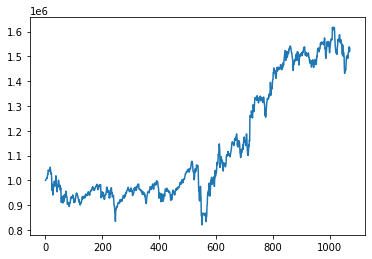

In [ ]:
ensemble_account_value.account_value.plot()

In [ ]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  0.6355147614859653


In [ ]:
ensemble_account_value

,account_value,date,daily_return
0,1.000000e+06,20180102,NaN
1,1.000638e+06,20180103,0.000638
2,1.002703e+06,20180104,0.002064
3,1.006177e+06,20180105,0.003464
4,1.007769e+06,20180108,0.001582
...,...,...,...
1066,1.518255e+06,20220328,0.000543
1067,1.535337e+06,20220329,0.011251
1068,1.538666e+06,20220330,0.002168
1069,1.518984e+06,20220331,-0.012792


In [ ]:
ensemble_account_value['Date'] = test_dji['Date']

In [ ]:
ensemble_account_value

,account_value,date,daily_return,Date
0,1.000000e+06,20180102,NaN,2018-01-02
1,1.000638e+06,20180103,0.000638,2018-01-03
2,1.002703e+06,20180104,0.002064,2018-01-04
3,1.006177e+06,20180105,0.003464,2018-01-05
4,1.007769e+06,20180108,0.001582,2018-01-08
...,...,...,...,...
1066,1.518255e+06,20220328,0.000543,2022-03-28
1067,1.535337e+06,20220329,0.011251,2022-03-29
1068,1.538666e+06,20220330,0.002168,2022-03-30
1069,1.518984e+06,20220331,-0.012792,2022-03-31


In [ ]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1071])

In [ ]:
ensemble_strat.to_csv('/content/ensemble_strat.csv')

Start date,2018-01-02
End date,2022-04-01
Total months,51
,Backtest
Annual return,10.579%
Cumulative returns,53.321%
Annual volatility,18.545%
Sharpe ratio,0.64
Calmar ratio,0.44
Stability,0.79
Max drawdown,-23.863%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.86,2020-01-21,2020-03-12,2020-06-02,96
1,20.75,2018-01-26,2018-12-24,2020-01-15,514
2,11.52,2022-01-07,2022-03-08,NaT,NaN
3,9.56,2020-06-08,2020-06-26,2020-08-11,47
4,8.00,2020-09-02,2020-09-23,2020-10-22,37


Stress Events,mean,min,max
New Normal,0.05%,-7.53%,8.86%


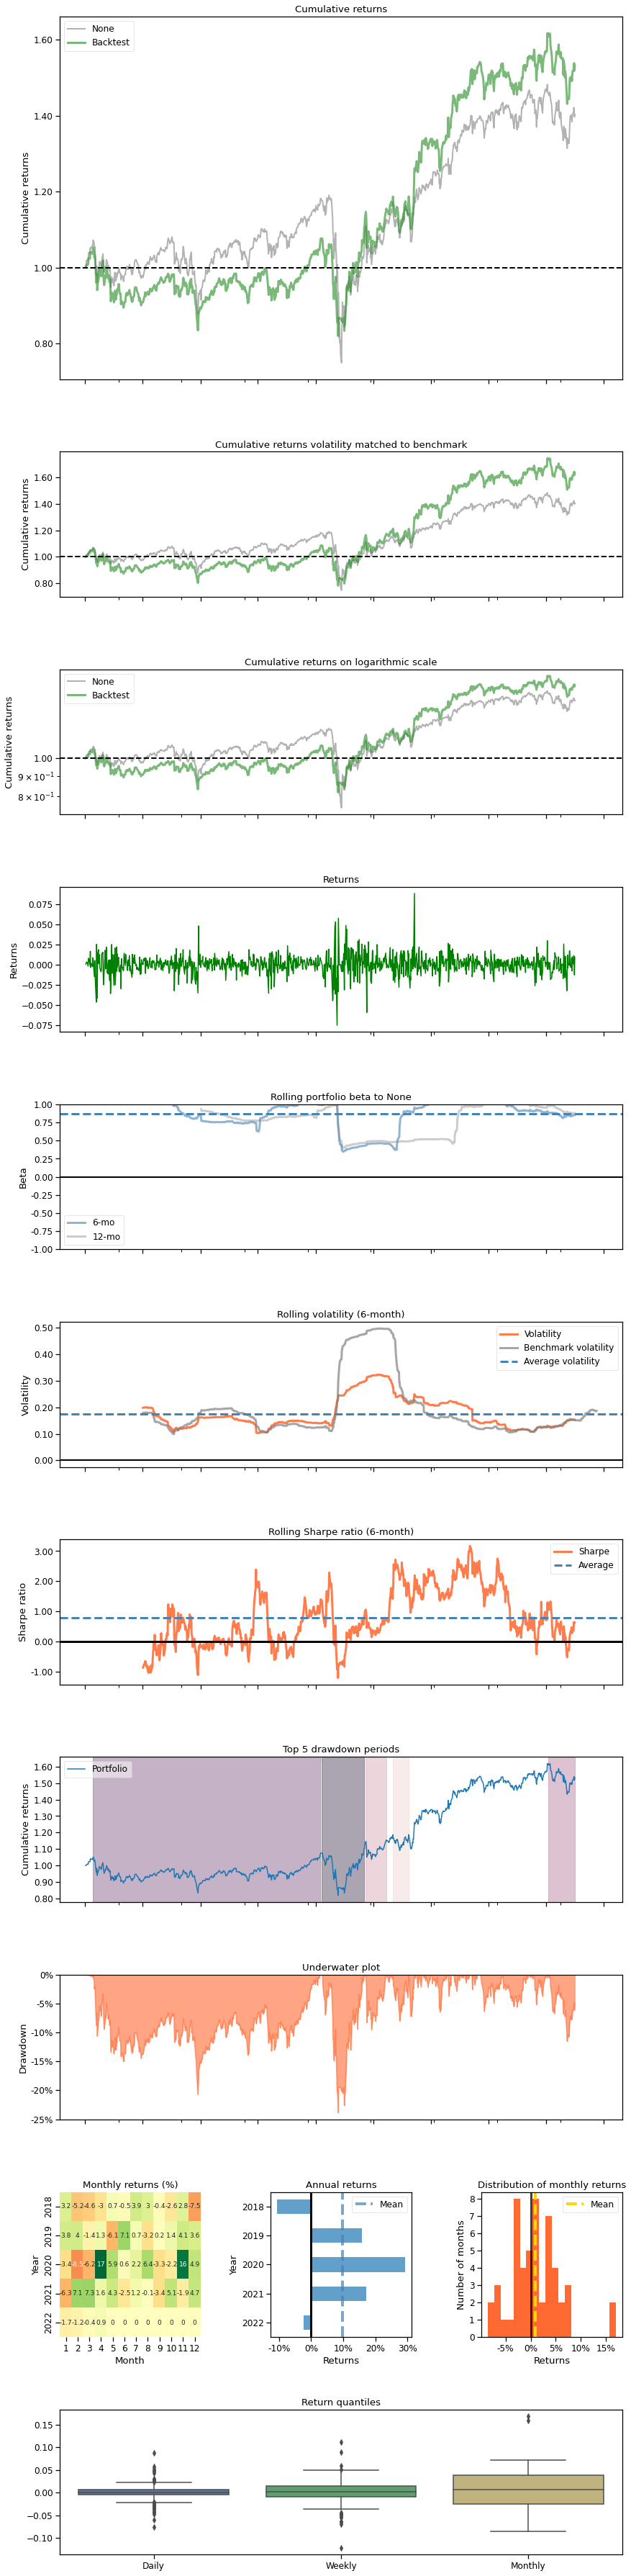

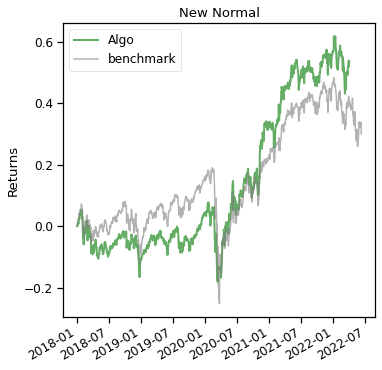

In [ ]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=dow_strat, set_context=False)